In [1]:
import pandas as pd #датафреймы
import numpy as np #массивы, линейная алгебра
import pylab as pl #графики
import matplotlib as mpl #графики
%matplotlib inline
%pylab inline
import seaborn as sns #красивые графики!
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


### Prepare data

We read data and delete those not being used

In [2]:
df=pd.read_csv('OUT_1.csv', index_col=False, header =0)
del df['Geomomentum']

We round "seconds" so that they are float (it's okay because timedeltas will be much bigger) and delete a few rows with seconds=60.

In [3]:
import math
df.Second=df.Second.astype(int)
df.drop(df.loc[df.Second==60].index, inplace=True)

We get dates and timedeltas, then convert them to logarithmic scale

In [4]:
import datetime
df.string=df.Year.astype(str)+'-'+df.Month.astype(str)+'-'+df.Day.astype(str)+' '+df.Hour.astype(str)+':'+df.Minute.astype(str)+':'+df.Second.astype(str)

In [5]:
df['Date']=pd.to_datetime(df.string)

In [6]:
df['t']=df['Date'].diff().fillna(0)

In [7]:
df['logtime']=df.t / np.timedelta64(1, 's')

We delete rows with timedelta=0 to avoid problems with log.

In [8]:
df.drop(df.loc[df.logtime==0].index, inplace=True)

In [9]:
df.logtime=df.logtime.apply(lambda x: math.log(x))

In [10]:
del df['Year']
del df['Month']
del df['Day']
del df['Hour']
del df['Minute']
del df['Second']

## Distributions

### Time interval distribution (log scale)

In [11]:
def frameEDF(sample,numbin):
    num=numbin+1
    F=[0 for i in range(num)]
    width=(sample.max()-sample.min())/(num-1)
    xedges=[sample.min()+(i)*width for i in range(num)]
    xcenters=[sample.min()+(i+0.5)*width for i in range(num-1)]
    #print xedges
    for i in range(num):
        #F[i]=len(sample.loc[((sample <= xedges[i]) &(sample > xedges[i-1]))])
        F[i]=len(sample.loc[sample <= xedges[i]])/float(len(sample))
    return xedges,F,width
def distance(xedges1,F1,xedges2,F2):
    F=[0 for i in range(len(F1))]
    for i in range(len(F1)):
        F[i]=abs(F1[i]-F2[i])
    return max(F)

In [12]:
def distanceplot(sample,window,bins):
    length=len(sample)-2*window
    dist=[0 for i in range(length)]
    for i in range(length):
        xedges1,F1,width1=frameEDF(sample[i:i+window],bins)
        xedges2,F2,width2=frameEDF(sample[i+window:i+2*window],bins)
        dist[i]=distance(xedges1,F1,xedges2,F2)
    return dist

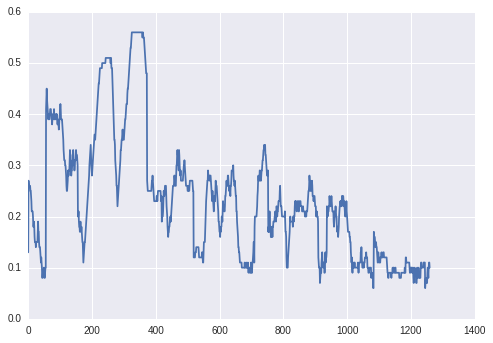

In [13]:
plt.plot(distanceplot(df.Depth,100,20))

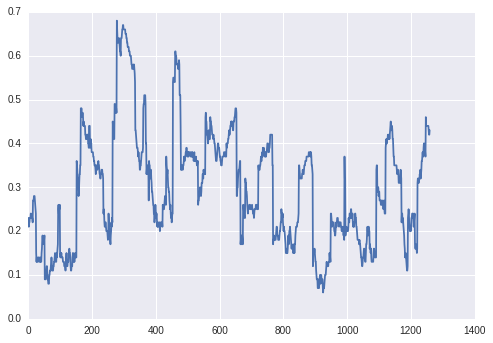

In [14]:
plt.plot(distanceplot(df.Magnitude,100,40))

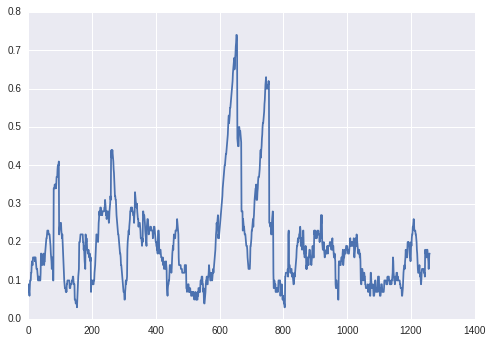

In [15]:
plt.plot(distanceplot(df.logtime,100,15))

In [ ]:
plt.bar(xedges1,F,width1)

In [ ]:
def frameEDFplot(sample,window,bins):
    elements=((len(sample)-window)*(bins+1))
    #print 'elements '+str(elements)
    xpos=[0 for i in range(elements)]
    ypos=[0 for i in range(elements)]
    zpos=[0 for i in range(elements)]
    #print 'i in '+ str((len(sample)-window))
    for i in range(len(sample)-window):
        #print frameEDF(sample[i:i+window],bins)
        print sample[i:i+window]
        xedges,F,width=frameEDF(sample[i:i+window],bins)
        yedges=[(i+1) for j in range(len(xedges))]
        #print yedges
        xpos[i*(bins+1):(i+1)*(bins+1)]=xedges
        ypos[i*(bins+1):(i+1)*(bins+1)]=yedges
        zpos[i*(bins+1):(i+1)*(bins+1)]=F
    return xpos,ypos,zpos

In [ ]:
frameEDFplot(df.Depth[1:13],10,6)

In [ ]:
#from mpl_toolkits.mplot3d import Axes3D
#import matplotlib.pyplot as plt
#import numpy as np

fig = plt.figure()
ax1 = fig.add_subplot(111, projection='3d')

xpos,ypos,dz=frameEDF(df.Depth[1:10],3)
#num_elements = len(xpos)
#zpos = [0 for i in range(len(xpos))]
#dx = np.ones(len(xpos))
#dy = np.ones(len(xpos))
#dz = [1,2,3,4,5,6,7,8,9,10]
Axes3D.scatter(xpos, ypos, dz, zdir='z', s=1, c='b', depthshade=True)
#ax1.bar3d(xpos, ypos, zpos, dx, dy, dz, color='#00ceaa')
plt.show()

In [ ]:
from scipy.interpolate import griddata

fig = plt.figure(figsize=plt.figaspect(0.5))
ax = fig.gca(projection='3d')
X = xpos
Y = ypos
Z = dz

xi = np.linspace(X.min(),X.max(),1000)
yi = np.linspace(Y.min(),Y.max(),1000)

zi = griddata((X, Y), Z, (xi[None,:], yi[:,None]), method='cubic')

xig, yig = np.meshgrid(xi, yi)

surf = ax.plot_surface(xig, yig, zi,linewidth=0.5,color='DarkKhaki',alpha=0.50)

plt.show()